In [1]:
# Imports
from src.data_retrieval import init_osm
from src.preprocessing import load_roads, load_railways, load_water_polygons, get_local_crs, reproject_all, build_water_edges, prepare_water_geometries
from src.prepare_pois import load_pois_with_green, prepare_pois, assign_pois_to_blocks
from src.process_blocks import construct_blocks, filter_water_blocks, filter_small_blocks, filter_irregular_blocks, remove_false_water_blocks
from src.plotting import plot_block_graph, plot_ge_heatmap, plot_variance
from src.construct_graph import build_block_graph
from src.network_analysis import get_largest_component, prepare_category_dicts, compute_generalized_euclidean_matrix, load_Q, compute_and_store_Q, compute_variance, compute_z_scores
from src.network_distance import ge, _ge_Q, variance, _resistance, calculate_spl


In [2]:
import numpy as np
import pandas as pd
import random
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import matplotlib.colors as colors


Setup

In [3]:
# CITY_NAME = "Copenhagen"
CITY_NAME = "Gdansk"

# Initialize OSM
osm, boundary = init_osm(CITY_NAME)

Downloaded Protobuf data 'Gdansk.osm.pbf' (36.64 MB) to:
'/home/zuziaderylo/masters_thesis/data/raw/Gdansk.osm.pbf'


In [4]:
roads = load_roads(osm)
railways = load_railways(osm)
water_polygons = load_water_polygons(osm)
pois = load_pois_with_green(osm)

/home/zuziaderylo/anaconda3/envs/masters/lib/python3.11/site-packages/pyrosm/networks.py:37: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  edges, nodes = prepare_geodataframe(


Loaded 32975 regular POIs
Loaded 251 green-space features
Total combined POIs: 33226


In [5]:
# Compute city-local UTM projection
local_epsg = get_local_crs(boundary)
print(f"Using local CRS: EPSG:{local_epsg}")

# Reproject all at once
layers = {
    "boundary": boundary,
    "roads": roads,
    "railways": railways,
    "water_polygons": water_polygons,
    "pois": pois
}
layers = reproject_all(layers, local_epsg)

# Unpack
boundary = layers["boundary"]
roads = layers["roads"]
railways = layers["railways"]
water_polygons = layers["water_polygons"]
pois = layers["pois"]

Using local CRS: EPSG:32634


In [6]:
print(boundary.crs)

EPSG:32634


In [7]:
# Build water edges after reprojection
water_edges = build_water_edges(layers["water_polygons"])

# Change water geometries
water_polygons = prepare_water_geometries(water_polygons)

In [8]:
# Prepare pois
pois = prepare_pois(pois=pois)

Number of POIs after cleaning: 33203
Assigned categories for 18895 POIs (56.9% coverage)
Number of POIs after categorization: 33203


In [9]:
len(roads)

138387

In [10]:
len(water_edges)

1843

In [11]:
len(railways)

14543

In [12]:
# Create initial blocks
initial_blocks = construct_blocks(roads, railways, water_edges)

len(initial_blocks)

10155


Iteration 1:
Threshold = 557.68 m²
Small blocks found = 2177
 Merged 2177 small blocks.
 Remaining blocks = 6531

Iteration 2:
Threshold = 557.68 m²
Small blocks found = 0
No small blocks left


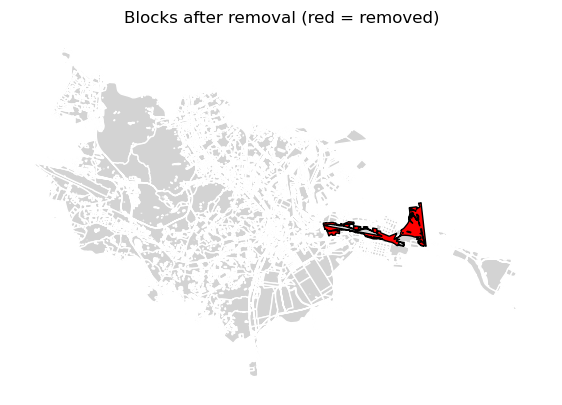

Removed 1 suspected false-water blocks (area>100%, compactness<4%).


/home/zuziaderylo/anaconda3/envs/masters/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/zuziaderylo/anaconda3/envs/masters/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/zuziaderylo/anaconda3/envs/masters/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be s

6006


/home/zuziaderylo/anaconda3/envs/masters/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [13]:
# Process blocks
blocks_no_water = filter_water_blocks(initial_blocks, water_polygons)
blocks_no_small = filter_small_blocks(blocks_no_water)
blocks_cleaned = remove_false_water_blocks(blocks_no_small, area_quantile=0.999, compactness_quantile=0.04,poi_column="poi_count")
blocks_no_irregular = filter_irregular_blocks(blocks_cleaned)

blocks = blocks_no_irregular

print(len(blocks))

In [14]:
blocks_with_pois = assign_pois_to_blocks(pois, blocks)

blocks = blocks_with_pois

POIs assigned to 2273 blocks (out of 6006)


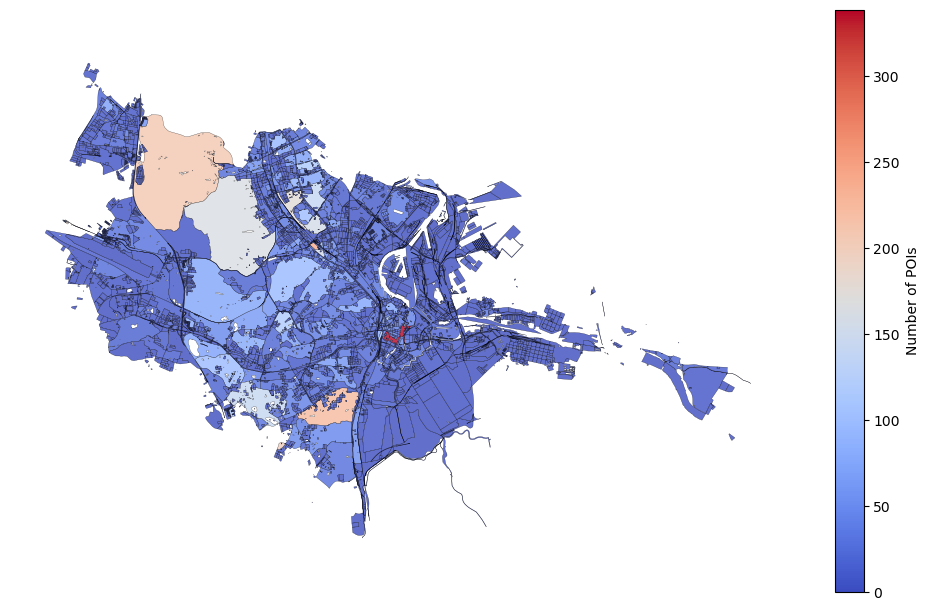

In [15]:
# Plot heatmap of POI counts
fig, ax = plt.subplots(figsize=(10, 10))

# Plot blocks, colored by number of POIs
blocks_with_pois.plot(
    ax=ax,
    column="poi_count",
    cmap="coolwarm",
    legend=True,
    legend_kwds={"label": "Number of POIs", "shrink": 0.6},
    edgecolor="black",
    linewidth=0.2,
    alpha = 0.8
)

# Title and formatting
# ax.set_title("Heatmap of POI Density per Block", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()

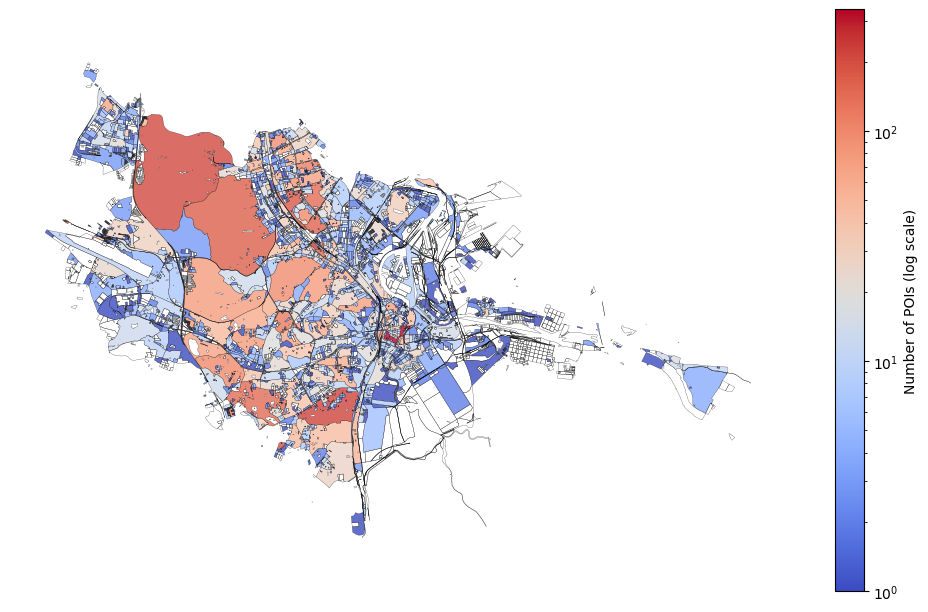

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot with logarithmic color normalization
blocks_with_pois.plot(
    ax=ax,
    column="poi_count",
    cmap="coolwarm",
    norm=colors.LogNorm(vmin=blocks_with_pois["poi_count"].min() + 1,  # +1 avoids log(0)
                        vmax=blocks_with_pois["poi_count"].max()),
    legend=True,
    legend_kwds={
        "label": "Number of POIs (log scale)",
        "shrink": 0.6
    },
    edgecolor="black",
    linewidth=0.2,
    alpha=0.8
)

ax.axis("off")
plt.tight_layout()
plt.show()


In [17]:
# Compute area and save as CSV (only the numbers, not the geometry)
blocks["area"] = blocks.geometry.area
blocks[["area"]].to_csv("block_sizes_gdansk.csv", index=False)

In [18]:
avg_block_area = blocks["area"].mean()
print("Average block area:", round(avg_block_area, 2))

Average block area: 30693.34


In [19]:
block_area_var = blocks["area"].var()
print("Block area variance:", round(block_area_var, 2))

Block area variance: 52662838332.06


In [20]:
q25 = blocks["area"].quantile(0.25)
q75 = blocks["area"].quantile(0.75)

area_total = blocks["area"].sum()
area_small = blocks.loc[blocks["area"] <= q25, "area"].sum() / area_total
area_large = blocks.loc[blocks["area"] >= q75, "area"].sum() / area_total

print(f"Area share of small blocks (<25th): {area_small:.2%}")
print(f"Area share of large blocks (>75th): {area_large:.2%}")

Area share of small blocks (<25th): 0.83%
Area share of large blocks (>75th): 90.37%


In [21]:
blocks["perimeter"] = blocks.geometry.length
blocks["compactness"] = (4 * np.pi * blocks["area"]) / (blocks["perimeter"] ** 2)
avg_compactness = blocks["compactness"].mean()
print("Average compactness:", round(avg_compactness, 3))

Average compactness: 0.486


In [22]:
n_pois = len(pois)
pois_per_block = n_pois / len(blocks)
print(f"Number of POIs: {n_pois}")
print(f"POIs per block: {pois_per_block:.2f}")

Number of POIs: 33203
POIs per block: 5.53


Graph

In [23]:
# Build graph from blocks with POIs
G = build_block_graph(blocks_with_pois)

Graph constructed: 6006 nodes, 16532 edges


(<Figure size 1200x1200 with 2 Axes>,
 <Axes: title={'center': 'Gdansk Network Graph'}>)

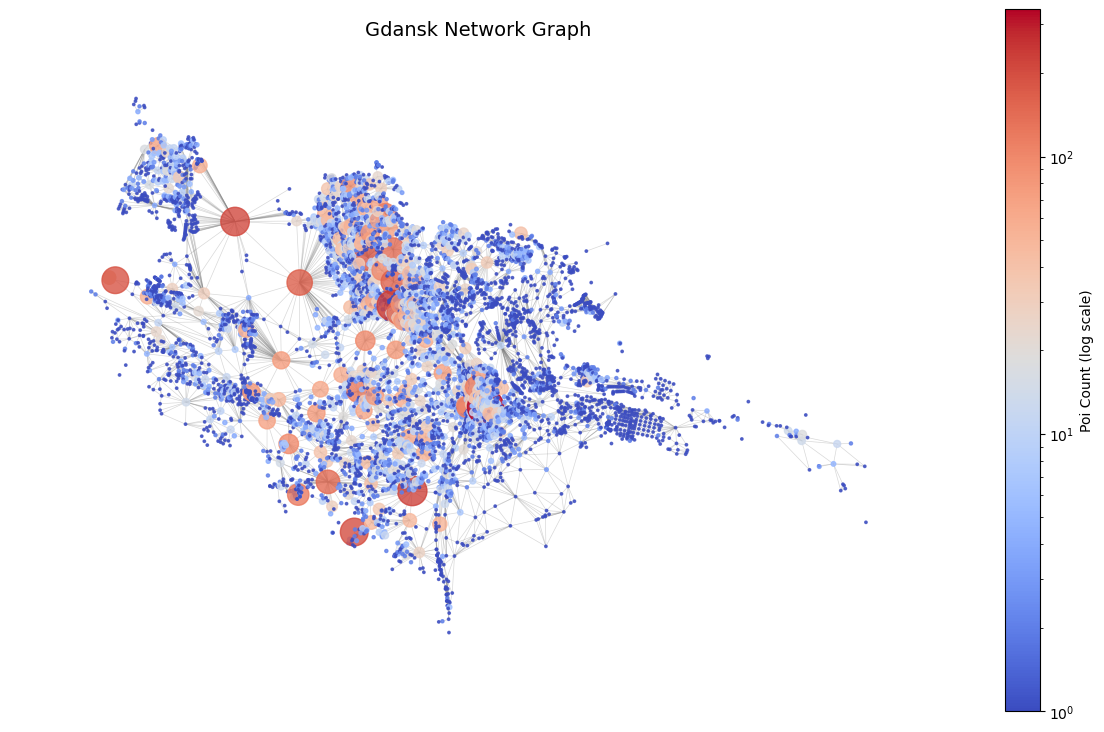

In [24]:
plot_block_graph(G, blocks, city_name=CITY_NAME, save_path="report/figures")

In [25]:
# Select largest connected component
G_largest = get_largest_component(G)

Graph has 92 components.
Largest component: 5800 nodes, 16360 edges.


In [26]:
avg_degree = sum(dict(G_largest.degree()).values()) / G_largest.number_of_nodes()
print("Average degree:", round(avg_degree, 3))

Average degree: 5.641


In [27]:
density = nx.density(G_largest)
print("Density:", round(density, 5))

Density: 0.00097


Checking number of components and why they are not connected

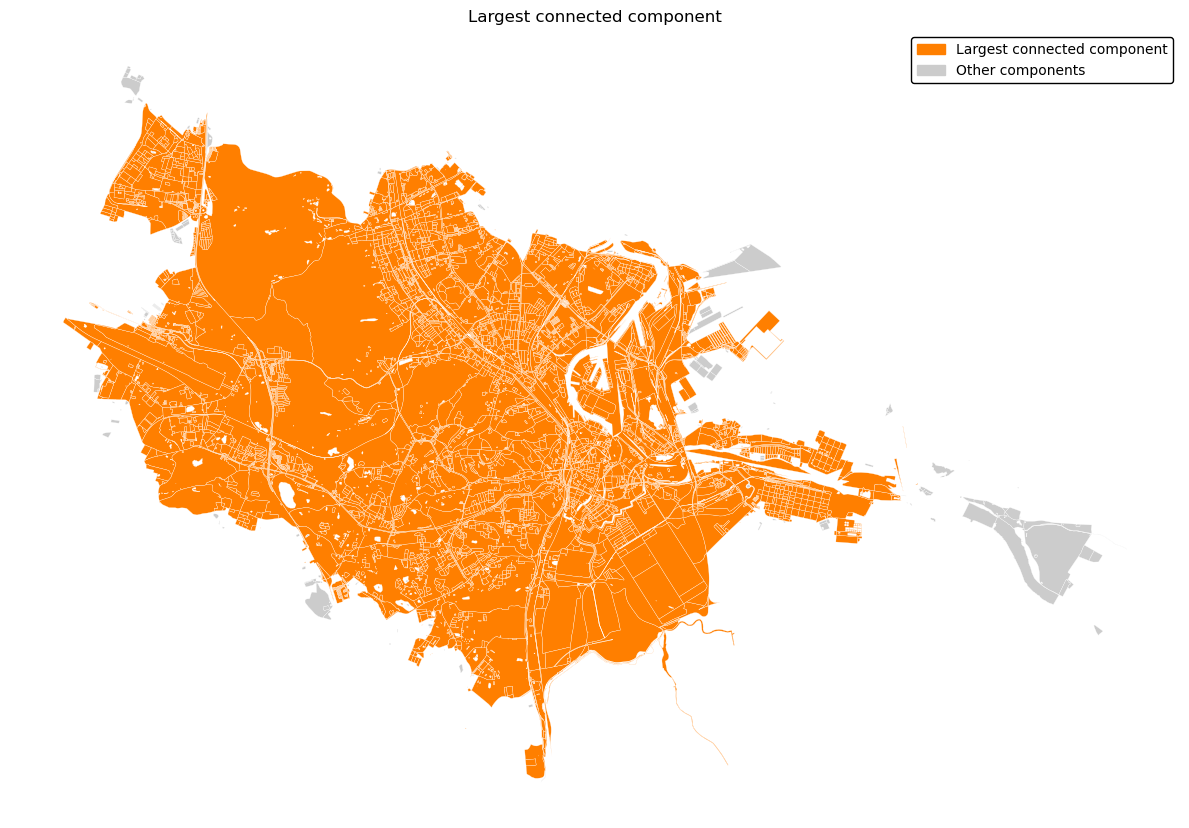

In [28]:
import matplotlib.patches as mpatches

largest = max(nx.connected_components(G), key=len)
blocks["in_largest"] = blocks["block_id"].isin(largest)

fig, ax = plt.subplots(figsize=(12, 12))

color_map = {
    True:  "#ff7f00",   # bright orange
    False: "#cccccc"    # medium gray
}



# Plot blocks
blocks.plot(
    ax=ax,
    color=blocks["in_largest"].map(color_map),
    edgecolor="white",
    linewidth=0.2
)

# Remove axes/frame
ax.set_axis_off()

# --- Title ---
ax.set_title(
    "Largest connected component",
    fontsize=12,
)

# --- Custom legend ---
legend_handles = [
    mpatches.Patch(color="#ff7f00", label="Largest connected component"),
    mpatches.Patch(color="#cccccc", label="Other components")
]

ax.legend(
    handles=legend_handles,
    loc="upper right",
    frameon=True,          # small box around legend
    framealpha=1.0,        # opaque box
    facecolor="white",     # white background
    edgecolor="black"      # border color
)

plt.tight_layout()

plt.savefig(
    "gdansk_largest_component.pdf",
    format="pdf",
    bbox_inches="tight",
    pad_inches=0
)

plt.show()


In [28]:
# Compute Q
Q = compute_and_store_Q(G_largest, CITY_NAME)

In [29]:
# Load 
G_largest, Q = load_Q(CITY_NAME)

Graph nodes: 5771, Q shape: (5771, 5771)


In [30]:
# Prepare category dictionaries
category_counts = blocks_with_pois.attrs["category_counts"]
category_dicts_largest = prepare_category_dicts(category_counts, G_largest)

In [31]:
# Compute GE matrix
df_ge = compute_generalized_euclidean_matrix(G_largest, category_dicts_largest, ge_func=ge, Q_func=lambda G: Q)

df_ge.to_csv("data/processed/Gdansk_results_GE.csv", index=False)

In [32]:
df_ge.shape

(9, 9)

In [33]:
df_ge.values.mean()

0.07183383219675481

In [34]:
print(len(pois))

32892


In [27]:
# Plot heatmap
plot_ge_heatmap(df_ge, city_name=CITY_NAME, save_path="report/figures")

(<Figure size 1000x800 with 2 Axes>,
 <Axes: title={'center': 'Gdansk Generalized Euclidean Distance between Amenity Categories'}>)

In [28]:
# Precompute resistance once
def precompute_resistance(G_largest):
    resistance_matrix = _resistance(G_largest)

    return resistance_matrix

In [29]:
resistance_matrix = precompute_resistance(G_largest)

In [30]:
# Compute variance for each category (using precomputed resistance matrix)
variance_categories = compute_variance(category_dicts_largest, G_largest, resistance_matrix)

                          variance
infrastructure_transport  0.547827
culture_leisure           0.254822
retail                    0.312622
other_daily_utilities     0.371098
green_spaces              0.305180
healthcare                0.332670
public_services           0.397579
education                 0.317609
food                      0.287729


In [31]:
plot_variance(variance_categories, city_name=CITY_NAME, save_path="report/figures")

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Gdansk Variance per Amenity Category'}, ylabel='Variance'>)

In [32]:
# Generate distribution of variances from shuffled pois
def shuffled_variances(v_dict, G, resistance_matrix, n_iter=1000):
    # Store variance values from each shuffle
    results = []

    #Extract node IDs and their associated values separately
    nodes = list(v_dict.keys()) # stay fix
    values = list(v_dict.values()) # to shuffle

    # Perform random shuffling multiple times
    for _ in range(n_iter):
        # Shuffle POI values
        random.shuffle(values)

        # Reassign shuffled values to nodes
        shuffled_v = dict(zip(nodes, values))

        # Compute variance for this shuffled configuration
        var_random = variance(shuffled_v, G, shortest_path_lengths=resistance_matrix, kernel="resistance")
        
        # Store
        results.append(var_random)

    return np.array(results)


In [33]:
# For each POI category:
# 1. Compute real variance
# 2. Generate random variance distribution
# 3. Compute z-score
def compute_z_scores(category_dicts, G, resistance_matrix, n_iter=1000):
    # Store results for all categories
    random_stats = {}

    # Iterate over each POI category
    for category, v_dict in category_dicts.items():
        # Compute real variance
        real_var = variance(v_dict, G,
                            shortest_path_lengths=resistance_matrix,
                            kernel="resistance")
        
        # Generate dstribution from shuffled data
        rand_vars = shuffled_variances(v_dict, G, resistance_matrix, n_iter)

        # Compute mean and standard deviation
        mean_rand = np.mean(rand_vars)
        std_rand = np.std(rand_vars)

        # Compute z-score
        # Positive z => more spread out than random
        # Negative z => more clustered than random
        z = (real_var - mean_rand) / std_rand if std_rand > 0 else np.nan

        # Store all results for this category: variance, average of random variances, standard deviation if random variances, normalized difference
        random_stats[category] = {
            "real_var": real_var,
            "mean_rand": mean_rand,
            "std_rand": std_rand,
            "z_score": z,
            "rand_vars": rand_vars
        }

    # Return as dataframe
    return pd.DataFrame.from_dict(random_stats, orient="index")


In [34]:
df_z = compute_z_scores(category_dicts_largest, G_largest, resistance_matrix, n_iter=1000)

In [35]:
# Store after computing df_z
SAVE_DIR = "data/processed"
df_z.to_csv(f"{SAVE_DIR}/{CITY_NAME}_results_z_scores.csv", index=True)

In [36]:
def plot_variance_distribution_from_results(category, df_z):
    rand_vars = df_z.loc[category, "rand_vars"]
    real_var = df_z.loc[category, "real_var"]
    mean_rand = df_z.loc[category, "mean_rand"]
    std_rand = df_z.loc[category, "std_rand"]
    z = df_z.loc[category, "z_score"]

    plt.figure(figsize=(8,5))
    plt.hist(rand_vars, bins=30, color="lightblue", edgecolor="black", alpha=0.7)
    plt.axvline(real_var, color="red", linestyle="--", label=f"Real var = {real_var:.4f}")
    plt.axvline(mean_rand, color="black", linestyle=":", label=f"Mean = {mean_rand:.4f}")
    plt.title(f"{category} — Z = {z:.2f}")
    plt.xlabel("Variance")
    plt.ylabel("Count")
    plt.legend()
    plt.show()


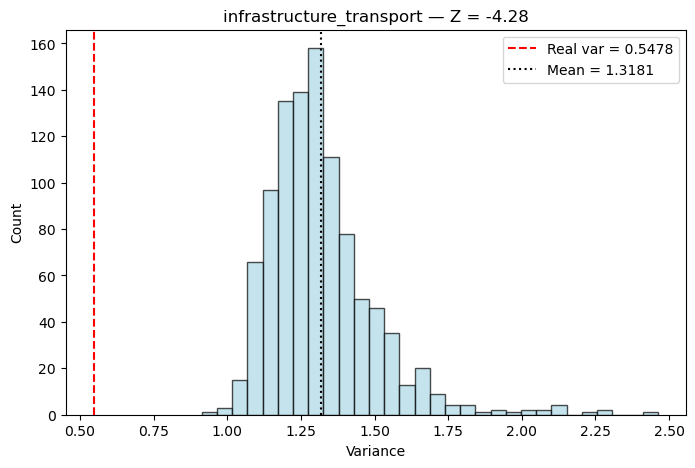

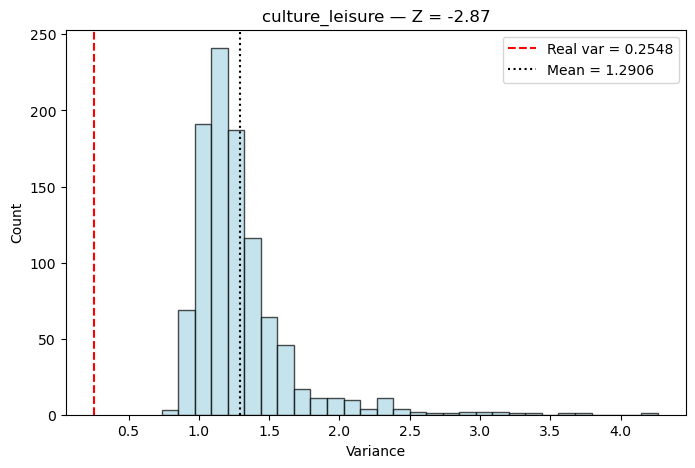

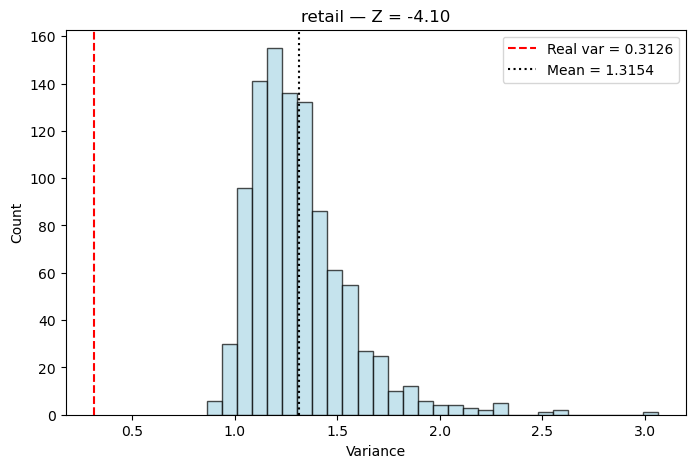

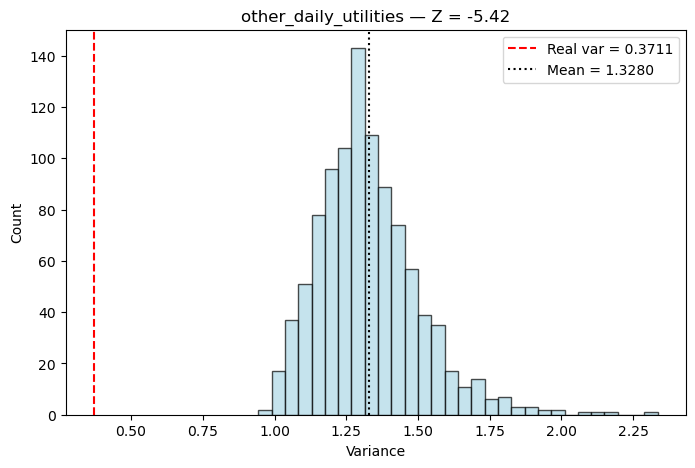

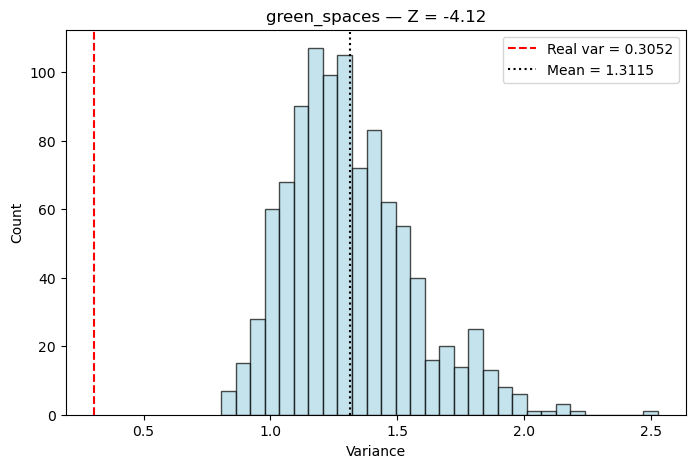

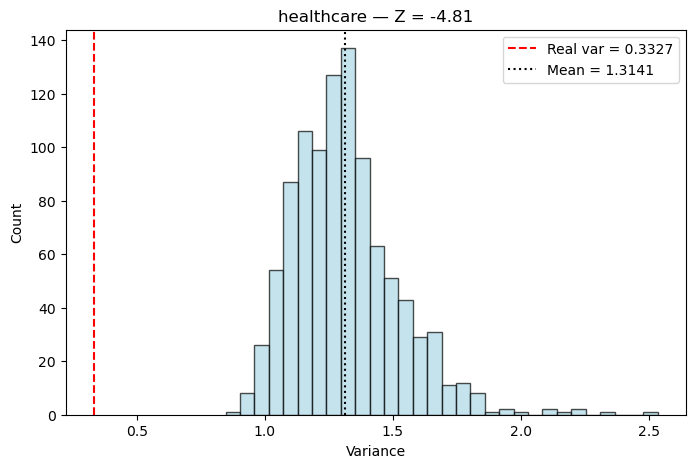

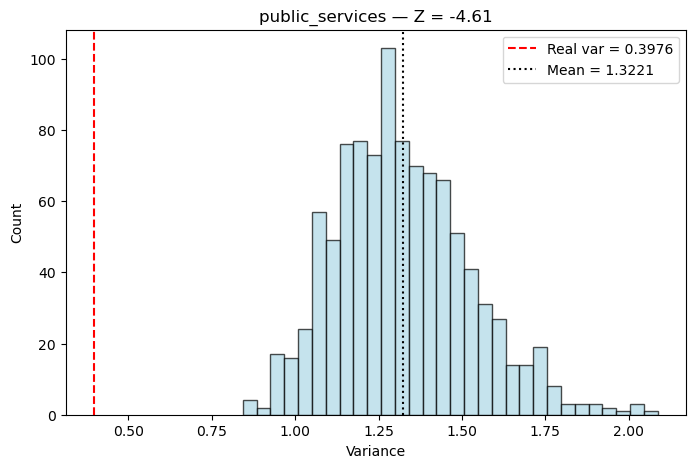

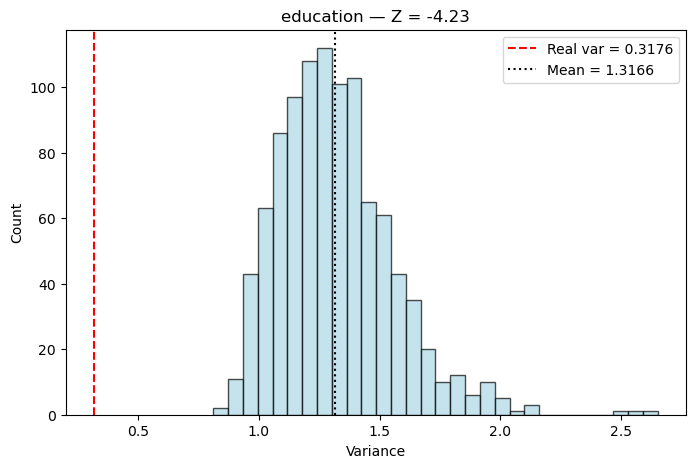

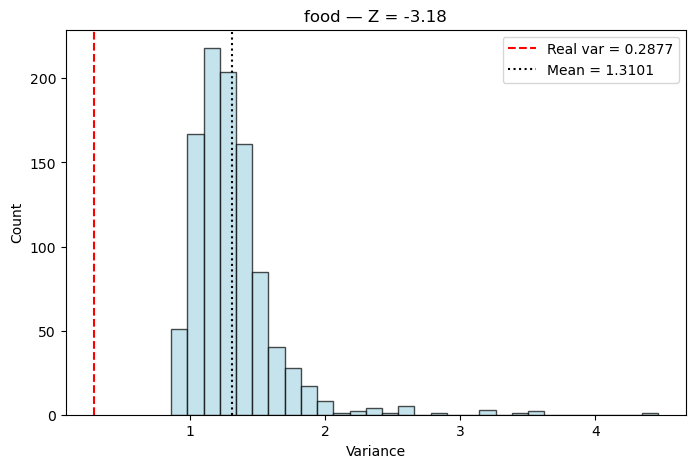

In [37]:
for category in df_z.index:
    plot_variance_distribution_from_results(category, df_z)


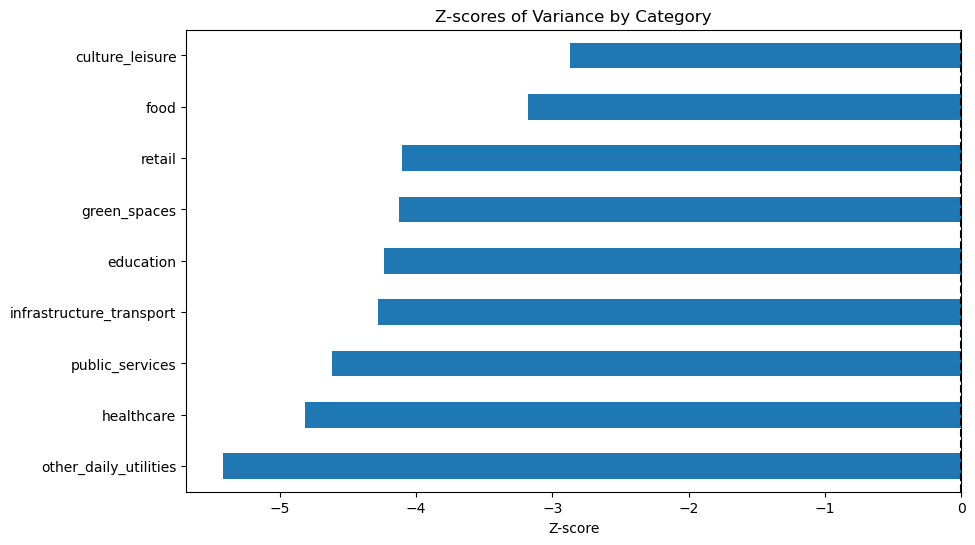

In [38]:
df_z["z_score"].sort_values().plot(kind="barh", figsize=(10,6))
plt.axvline(0, color="black", linestyle="--")
plt.title("Z-scores of Variance by Category")
plt.xlabel("Z-score")
plt.show()

Livability score

In [39]:
# Check the list of z-scores and rhe rows of GE matrix are consistens
print("Categories in GE:", df_ge.index.tolist())
print("Categories in z:", df_z.index.tolist())

Categories in GE: ['infrastructure_transport', 'culture_leisure', 'retail', 'other_daily_utilities', 'green_spaces', 'healthcare', 'public_services', 'education', 'food']
Categories in z: ['infrastructure_transport', 'culture_leisure', 'retail', 'other_daily_utilities', 'green_spaces', 'healthcare', 'public_services', 'education', 'food']


In [40]:
# Align df_z to the same order as df_ge. So they correspond exactly
df_z_aligned = df_z.reindex(df_ge.index)

# Save z-scores
z_scores = df_z_aligned["z_score"].values

In [41]:
# Check if it worked, if the z-scores match
for cat, z in zip(df_ge.index, z_scores):
    print(f"{cat}: {z}")

infrastructure_transport: -4.282151671345588
culture_leisure: -2.8689070854107706
retail: -4.102227142390848
other_daily_utilities: -5.416093079179145
green_spaces: -4.1237562115384385
healthcare: -4.812862692330398
public_services: -4.614246488842889
education: -4.233752538855459
food: -3.1799952073103785


In [42]:
df_ge.head()

,infrastructure_transport,culture_leisure,retail,other_daily_utilities,green_spaces,healthcare,public_services,education,food
infrastructure_transport,0.000000,0.102753,0.087548,0.059209,0.087967,0.086212,0.092169,0.071610,0.126474
culture_leisure,0.102753,0.000000,0.093912,0.092991,0.075007,0.103921,0.067353,0.092958,0.080484
retail,0.087548,0.093912,0.000000,0.068555,0.069768,0.048601,0.074128,0.058292,0.097786
other_daily_utilities,0.059209,0.092991,0.068555,0.000000,0.072535,0.072526,0.074898,0.049832,0.117077
green_spaces,0.087967,0.075007,0.069768,0.072535,0.000000,0.072869,0.053046,0.060084,0.086953


In [43]:
# First livability score. 
def compute_livability_from_matrix(df_ge, z_scores):
    # Take ge matrix
    GE = df_ge.values
    # Convert z-scores into array and take absolute values
    z = np.abs(np.array(z_scores, dtype=float))
    # Change the shape of z to column vector and muptiply by ge
    scaled = z[:, None] * GE
    # Sum values
    total = scaled.sum()
    # Invert 
    return 1 / total if total != 0 else np.nan


In [44]:
# Livabiity score for the city
livability = compute_livability_from_matrix(df_ge, z_scores)
print("Livability score:", livability)

Livability score: 0.04157892370429916


Normalization 1 - use the average instead of the sum

In [45]:
# Livability score
def compute_livability_normalized_1(df_ge, z_scores):
    # Take ge matrix
    GE = df_ge.values

    # Convert z-scores into array and take absolute values
    z = np.abs(np.array(z_scores, dtype=float))

    # Change the shape of z to column vector and muptiply by ge
    scaled = z[:, None] * GE

    # Number of categories
    n=len(z)

    # Sum values
    sum = scaled.sum()

    # Average 
    average = sum/(n*(n-1))

    # Invert 
    return 1 / average if average != 0 else np.nan

In [46]:
# Livabiity score for the city
livability_normalized1 = compute_livability_normalized_1(df_ge, z_scores)
print("Livability score (with using average instead of sum):", livability_normalized1)

Livability score (with using average instead of sum): 2.993682506709539


Normalization 2 - add weights to the edges in graph

In [47]:
list(G_largest.edges(data=True))[:20]

[(0, 1, {}),
 (0, 2, {}),
 (0, 3, {}),
 (1, 757, {}),
 (1, 722, {}),
 (1, 748, {}),
 (1, 699, {}),
 (1, 714, {}),
 (1, 664, {}),
 (1, 706, {}),
 (1, 652, {}),
 (1, 781, {}),
 (1, 836, {}),
 (1, 769, {}),
 (1, 880, {}),
 (1, 848, {}),
 (1, 244, {}),
 (1, 106, {}),
 (1, 20, {}),
 (1, 19, {})]

In [48]:
# Method for adding weigths to edges
def add_inv_degree_weights(G):
    deg = dict(G.degree())
    for u, v in G.edges():
        w = 0.5 * (1.0 / max(deg[u], 1) + 1.0 / max(deg[v], 1))
        G[u][v]["weight"] = float(w)
    return G

In [49]:
# Make a weighted copy of the graph
G_weighted = G_largest.copy()

# Add degree-based weights
G_weighted = add_inv_degree_weights(G_weighted)

# Recompute Q and GE matrix using the weighted graph
Q_weighted = compute_and_store_Q(G_weighted, CITY_NAME)

# Prepare category dictionaries
category_dicts_largest_weighted = prepare_category_dicts(category_counts, G_weighted)

# Compute GE matrix
df_ge_weighted = compute_generalized_euclidean_matrix(
    G_weighted, category_dicts_largest_weighted, ge_func=ge, Q_func=lambda G: Q_weighted
)

resistance_matrix_weighted = precompute_resistance(G_weighted)

# Compute variance for each category (using precomputed resistance matrix)
variance_categories_weighted = compute_variance(category_dicts_largest_weighted, G_weighted, resistance_matrix_weighted)

# Compute z-scores
df_z_weighted = compute_z_scores(category_dicts_largest_weighted, G_weighted, resistance_matrix_weighted, n_iter=1000)

# Align df_z to the same order as df_ge. So they correspond exactly
df_z_aligned_weighted = df_z_weighted.reindex(df_ge_weighted.index)

# Save z-scores
z_scores_weighted = df_z_aligned_weighted["z_score"].values

                           variance
infrastructure_transport  27.159810
culture_leisure           15.376052
retail                    18.771172
other_daily_utilities     21.582079
green_spaces              18.781642
healthcare                18.776337
public_services           22.139933
education                 18.617647
food                      16.180490


In [50]:
print(df_ge.compare(df_ge_weighted))

                         infrastructure_transport           culture_leisure  \
                                             self     other            self   
infrastructure_transport                      NaN       NaN        0.102753   
culture_leisure                          0.102753  0.298545             NaN   
retail                                   0.087548  0.249375        0.093912   
other_daily_utilities                    0.059209  0.155865        0.092991   
green_spaces                             0.087967  0.250794        0.075007   
healthcare                               0.086212  0.245462        0.103921   
public_services                          0.092169  0.261909        0.067353   
education                                0.071610  0.197681        0.092958   
food                                     0.126474  0.368057        0.080484   

                                      retail           other_daily_utilities  \
                             other      self     o

In [51]:
# Compute livability score
livability_normalized2 = compute_livability_from_matrix(df_ge_weighted, z_scores_weighted)

print("Livability with weighted edges:", livability_normalized2)

Livability with weighted edges: 0.01461143105930902


Normalization 3 - normalizing generalized euclidean

In [52]:
# Normalize GE matrix so that all values sum to 1 - global 
def normalize_ge_sum_to_one(df_ge):
    GE = df_ge.values.astype(float).copy()
    np.fill_diagonal(GE, 0.0)             # ensure diagonal = 0
    s = GE.sum()                          # total sum of all distances
    if s > 0:
        GE = GE / s                       # divide all by total sum
    return pd.DataFrame(GE, index=df_ge.index, columns=df_ge.columns)

df_ge_sum1 = normalize_ge_sum_to_one(df_ge)

In [53]:
print("Sum of GE before:", df_ge.values.sum())
print("Sum of GE after :", df_ge_sum1.values.sum())

Sum of GE before: 5.826953810545741
Sum of GE after : 0.9999999999999999


In [54]:
# Compute livability again using normalized GE
livability_normalized3 = compute_livability_from_matrix(df_ge_sum1, z_scores)
print("Livability score (with normalized GE):", livability_normalized3)

Livability score (with normalized GE): 0.24227846791715663


In [55]:
# Row normalization; per category. Every row sum up to 1
def normalize_ge_rowwise(df_ge):
    GE = df_ge.values.astype(float).copy()
    np.fill_diagonal(GE, 0.0)
    row_sums = GE.sum(axis=1, keepdims=True)
    # avoid division by zero
    GE = np.divide(GE, row_sums, where=row_sums!=0)
    return pd.DataFrame(GE, index=df_ge.index, columns=df_ge.columns)

df_ge_row = normalize_ge_rowwise(df_ge)

In [56]:
livability_rowwise = compute_livability_from_matrix(df_ge_row, z_scores)
print("Livability score (row-normalized GE):", livability_rowwise)

Livability score (row-normalized GE): 0.0265717226300545


Normalization 4 - Logarithm of ge

In [57]:
# Copy GE matrix
GE = df_ge.values.astype(float)

# Replace zeros to avoid log(0)
GE[GE <= 0] = 1e-9

# Apply logarithm
GE_log = np.log(GE)

# Create DataFrame again
df_ge_log = pd.DataFrame(GE_log, index=df_ge.index, columns=df_ge.columns)

In [58]:
# Compute livability again
livability_log = compute_livability_from_matrix(df_ge_log, z_scores)
print("Livability (log-transformed GE):", livability_log)

Livability (log-transformed GE): -0.0006452631593988752


Testing the logic of the formula

In [59]:
# Test a livability computation function across multiple edge cases
# livability_func must take (z, GE) as inputs and return a numeric score.

def test_livability_method(livability_func):

    # Base example
    z = np.array([-11, -7, -5])
    GE = np.array([[0,1,2],[1,0,3],[2,3,0]])
    base = livability_func(z, GE)

    # Larger city (distances x10)
    large = livability_func(z, GE * 10)

    # Smaller city (distances /10)
    small = livability_func(z, GE * 0.1)

    # More POIs within the same category
    GE_more_pois = GE * 0.9  # smaller = denser categories
    many = livability_func(z, GE_more_pois)

    # All z = 0
    z_balanced = np.zeros_like(z)
    balanced = livability_func(z_balanced, GE)

    # No POIs
    empty = livability_func([], np.zeros((0,0)))

    print("Base city:", base)
    print("Larger city (distances bigger):", large)
    print("Smaller city (distances smaller):", small)
    print("More POIs:", many)
    print("All z=0 (perfect balance):", balanced)
    print("No POIs:", empty)


In [60]:
def livability_unnormalized(z, GE):
    if len(z) == 0:
        return np.nan
    z = np.abs(z)
    return 1 / ((z[:, None] * GE).sum() + 1e-9)


print("Unnormalized:")
test_livability_method(livability_unnormalized)

Unnormalized:
Base city: 0.011627906976608978
Larger city (distances bigger): 0.0011627906976730666
Smaller city (distances smaller): 0.11627906975392102
More POIs: 0.012919896640659949
All z=0 (perfect balance): 999999999.9999999
No POIs: nan


In [61]:
def livability_average(z, GE):
    if len(z) < 2:
        return np.nan
    z = np.abs(z)
    n = len(z)
    total = (z[:, None] * GE).sum() / (n * (n - 1))
    return 1 / (total + 1e-9)


print("Normalization 1:")
test_livability_method(livability_average)

Normalization 1:
Base city: 0.06976744185559762
Larger city (distances bigger): 0.006976744185997837
Smaller city (distances smaller): 0.6976744181179014
More POIs: 0.07751937983895198
All z=0 (perfect balance): 999999999.9999999
No POIs: nan


In [62]:
# The whole ge matrix sum to one
def livability_sum1(z, GE):
    if len(z) == 0:
        return np.nan
    z = np.abs(z)
    GE = GE.astype(float).copy()
    np.fill_diagonal(GE, 0)
    s = GE.sum()
    if s > 0:
        GE = GE / s
    return 1 / ((z[:, None] * GE).sum() + 1e-9)

print("Normalization 3:")
test_livability_method(livability_sum1)

Normalization 3:
Base city: 0.13953488370146025
Larger city (distances bigger): 0.13953488370146025
Smaller city (distances smaller): 0.13953488370146025
More POIs: 0.13953488370146025
All z=0 (perfect balance): 999999999.9999999
No POIs: nan


In [63]:
# Row normalization: each category's distances sum to 1
def livability_row_normalized(z, GE):
    if len(z) == 0:
        return np.nan

    z = np.abs(z)
    GE = GE.astype(float).copy()

    row_sums = GE.sum(axis=1, keepdims=True)
    GE = np.divide(GE, row_sums, where=row_sums != 0)
    np.fill_diagonal(GE, 0.0)

    total = (z[:, None] * GE).sum()
    return 1 / (total + 1e-9)

print("Normalization 3:")
test_livability_method(livability_row_normalized)

Normalization 3:
Base city: 0.04347826086767486
Larger city (distances bigger): 0.04347826086767486
Smaller city (distances smaller): 0.04347826086767486
More POIs: 0.04347826086767486
All z=0 (perfect balance): 999999999.9999999
No POIs: nan


In [64]:
def livability_log(z, GE):
    if len(z) == 0:
        return np.nan
    z = np.abs(z)
    GE = GE.astype(float).copy()
    GE[GE <= 0] = 1e-9
    GE = np.log(GE)
    return 1 / ((z[:, None] * GE).sum() + 1e-9)


print("Normalization 4:")
test_livability_method(livability_log)

Normalization 4:
Base city: -0.002210621803060352
Larger city (distances bigger): -0.0028864819035638316
Smaller city (distances smaller): -0.0017912148308253184
More POIs: -0.002187188346635496
All z=0 (perfect balance): 999999999.9999999
No POIs: nan
